## Dependencias

In [237]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from datetime import date,time,datetime
from dateutil.relativedelta import relativedelta as rd

from sqlalchemy.engine import create_engine
from sqlalchemy.types import BIGINT,INT,VARCHAR,CHAR,BLOB,DATE,DATETIME,NUMERIC,FLOAT,TEXT,BOOLEAN

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer

from varclushi import VarClusHi
from scipy import stats

from functools import reduce

import json 
import glob 
import os

from multiprocessing import Pool

pd.set_option('display.max_columns',None)
pd.set_option('display.float_format',lambda x:'%.2f'%x)

cf.go_offline()

In [12]:
def make_pool(func, params, threads):
    """
    Ejecuta de forma paralela múltiples llamadas a una función
    :param func: function, objeto función a paralelizar
    :param params: iterable, parámetros de evaluación paralela
    :param threads: int, número de hilos de multiprocesamiento
    :return: list, resultado de la ejecución paralela agrupada en una lista
    """
    pool = Pool(threads)
    data = pool.starmap(func, params)
    pool.close()
    pool.join()
    del pool
    return [x for x in data]

## Conexión Base de Datos

In [ ]:
creds = json.load(open('creds.json','rb'))
cnx = create_engine(f'mysql+pymysql://{creds["u"]}:{creds["p"]}@{creds["h"]}/{creds["d"]}').connect()
cnx.closed

## Lectura de datos y preparación universo inicial

In [ ]:
query = """
    SELECT 
        A.id_txn,
        A.id_user,
        A.amount,
        A.rej_reason,
        A.txn_type,
        A.is_fraud,
        A.ts,
        B.territory,
        B.mcc,
        C.gender,
        C.state,
        C.dob,
        D.card_brand,
        D.card_type,
        D.acct_open_date
    FROM
        tbl_txn A
            INNER JOIN
        tbl_merchant B USING (id_merchant)
            INNER JOIN
        tbl_user C USING (id_user)
            INNER JOIN
        tbl_card D USING (pan)
    ;
    """

In [ ]:
df = pd.read_sql(con=cnx,sql=query)

## Ingeniería de características

In [3]:
rs = np.random.RandomState(seed=20221015)

In [2]:
#df.to_pickle('txn.pkl')
df = pd.read_pickle('txn.pkl')

In [4]:
nof,f = [d.reset_index(drop=True) for _,d in df.groupby('is_fraud')]

In [5]:
nof = nof.sample(n=2000,random_state=rs).reset_index(drop=True)
f = f.sample(n=2000,random_state=rs).reset_index(drop=True)

In [6]:
muestra = pd.concat([nof,f],ignore_index=True)

In [7]:
muestra['hora'] = muestra['ts'].map(lambda x:x.hour)
muestra['mes'] = muestra['ts'].map(lambda x:x.month)
muestra['diasem'] = muestra['ts'].map(lambda x:x.weekday()).map(dict(zip(range(7),'LMXJVSD')))

In [8]:
muestra['edad_usuario'] = np.round((muestra['ts'].dt.date-muestra['dob'])/np.timedelta64(1,'Y'),1)
muestra['antig_cta'] = np.round((muestra['ts'].dt.date-muestra['acct_open_date'])/np.timedelta64(1,'Y'),1)

In [9]:
usuario = 262
ancla = datetime(2014,2,9,7,57)

def caract_pasado(usuario:int,ancla:datetime)->tuple:
    ancla = pd.to_datetime(ancla)
    aux = df.loc[(df['id_user']==usuario)&((df['ts']>=(ancla+rd(days=-30)))&(df['ts']<ancla))].copy().reset_index(drop=True)
    aux['hora'] = aux['ts'].map(lambda x:x.hour)
    aux['diasem'] = aux['ts'].map(lambda x:x.weekday())
    horas_freq = "|".join(map(str,sorted(aux['hora'].value_counts().head(3).index)))
    dias_freq  = "|".join(aux['diasem'].value_counts().head(3).sort_index().index.map(dict(zip(range(7),'LMXJVSD'))))
    tiempo_desde_ult_txn = (ancla-aux['ts'].max())/np.timedelta64(1,'s')
    monto_ult_txn = aux.loc[aux['ts']==aux['ts'].max()]['amount'].max()
    monto_prom = aux['amount'].mean()
    num_op = aux.shape[0]
    monto_prom_anio_pasado = df.loc[(df['id_user']==usuario)&((df['ts']>=(ancla+rd(years=-1,days=-30)))&(df['ts']<=ancla+rd(years=-1)))].copy().reset_index(drop=True)['amount'].mean()
    return horas_freq,dias_freq,tiempo_desde_ult_txn,monto_ult_txn,monto_prom,num_op,monto_prom_anio_pasado

In [10]:
caract_pasado(usuario,ancla)

('7|15|18', 'M|J|S', 1080.0, 66.0, 17.139908536585363, 328, 18.505357142857143)

In [18]:
nuevas_var = ['horas_frec','dias_frec','tiempo_desde_ult_txn',
'monto_ult_txn','monto_prom_ult_mes','num_txn_ult_mes','monto_prom_anio_pasado']
#muestra ['vector'] = np.vectorize(caract_pasado)(muestra['id_user'],muestra['ts'])

In [13]:
vectores = make_pool(caract_pasado,[(u,a) for u,a in zip(muestra['id_user'],muestra['ts'])],100)

In [15]:
muestra['vector'] = vectores

In [19]:
muestra[nuevas_var] = muestra['vector'].apply(pd.Series)

In [21]:
muestra.drop('vector',axis=1,inplace=True)

In [31]:
muestra['dif_estado'] = (muestra['territory']!=muestra['state']).astype(str)

In [32]:
#muestra.to_pickle('muestra.pkl')
muestra = pd.read_pickle('muestra.pkl')

In [33]:
muestra.shape

(4000, 28)

In [34]:
muestra.head(2)

,id_txn,amount,rej_reason,txn_type,is_fraud,ts,territory,mcc,gender,state,dob,card_brand,card_type,acct_open_date,id_user,hora,mes,diasem,edad_usuario,antig_cta,horas_frec,dias_frec,tiempo_desde_ult_txn,monto_ult_txn,monto_prom_ult_mes,num_txn_ult_mes,monto_prom_anio_pasado,dif_estado
0,12060187,44.91,None,S,0,2001-06-02 22:08:00,CA,5211,F,CA,1964-12-01,V,D,1999-07-01,956,22,6,S,36.5,1.9,10|17|21,L|S|D,6180.0,36.99,40.187101,69,39.87726,False
1,6325687,24.35,None,S,0,2009-03-27 14:19:00,MI,5813,M,MI,1980-10-01,V,D,2008-09-01,633,14,3,V,28.5,0.6,7|14|16,L|J|D,22320.0,24.49,34.627368,57,NaN,False


## Caracterización de variables

In [36]:
muestra.columns

Index(['id_txn', 'amount', 'rej_reason', 'txn_type', 'is_fraud', 'ts',
       'territory', 'mcc', 'gender', 'state', 'dob', 'card_brand', 'card_type',
       'acct_open_date', 'id_user', 'hora', 'mes', 'diasem', 'edad_usuario',
       'antig_cta', 'horas_frec', 'dias_frec', 'tiempo_desde_ult_txn',
       'monto_ult_txn', 'monto_prom_ult_mes', 'num_txn_ult_mes',
       'monto_prom_anio_pasado', 'dif_estado'],
      dtype='object')

In [37]:
um = ['id_txn']
varc = ['amount','edad_usuario','antig_cta','tiempo_desde_ult_txn',
       'monto_ult_txn', 'monto_prom_ult_mes', 'num_txn_ult_mes','monto_prom_anio_pasado']
vard = ['rej_reason','txn_type','hora', 'mes', 'diasem','horas_frec', 'dias_frec','dif_estado']
vart = ['is_fraud']

In [38]:
df = muestra[um+vart+vard+varc]

In [39]:
df.head()

,id_txn,is_fraud,rej_reason,txn_type,hora,mes,diasem,horas_frec,dias_frec,dif_estado,amount,edad_usuario,antig_cta,tiempo_desde_ult_txn,monto_ult_txn,monto_prom_ult_mes,num_txn_ult_mes,monto_prom_anio_pasado
0,12060187,0,None,S,22,6,S,10|17|21,L|S|D,False,44.91,36.5,1.9,6180.0,36.99,40.187101,69,39.877260
1,6325687,0,None,S,14,3,V,7|14|16,L|J|D,False,24.35,28.5,0.6,22320.0,24.49,34.627368,57,NaN
2,19414350,0,None,S,14,2,D,0|11|12,M|J|V,False,43.87,25.3,2.2,48600.0,65.36,38.351494,87,48.001071
3,7741346,0,None,S,16,10,V,7|8|16,V|S|D,False,45.34,25.9,5.7,93240.0,44.36,21.321786,28,22.697907
4,8688631,0,None,C,11,9,S,7|11|12,L|V|D,False,55.12,39.8,14.5,2160.0,10.24,38.478434,83,33.430000


## Partición

In [42]:
train,valid = train_test_split(df,train_size=0.7,random_state=rs)

In [44]:
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)

In [45]:
train.shape,valid.shape

((2800, 18), (1200, 18))

## Análisis Exploratorio de Datos

### Continuo

In [46]:
for v in varc:
    train[v] = pd.to_numeric(train[v],errors='coerce')

#### Ausentes

In [53]:
miss = 1-train[varc].describe().T/len(train)
miss.sort_values(by='count',ascending=False,inplace=True)
miss

,count,mean,std,min,25%,50%,75%,max
monto_prom_anio_pasado,0.060714,0.983996,0.980231,0.997843,0.989922,0.986157,0.981412,0.563314
amount,0.000000,0.975119,0.957218,1.173571,0.996055,0.984854,0.966607,0.471079
edad_usuario,0.000000,0.983217,0.994414,0.993571,0.987393,0.983821,0.979786,0.964857
antig_cta,0.000000,0.998101,0.998499,1.000000,0.999286,0.998429,0.997250,0.991107
tiempo_desde_ult_txn,0.000000,-9.650245,-14.228378,0.978571,-0.108929,-3.521429,-14.969643,-199.357143
monto_ult_txn,0.000000,0.982325,0.968642,1.165357,0.996830,0.989021,0.974529,0.507771
monto_prom_ult_mes,0.000000,0.984715,0.993262,0.997884,0.989588,0.985982,0.980968,0.948461
num_txn_ult_mes,0.000000,0.965987,0.981429,0.998214,0.977857,0.970357,0.958571,0.845714


In [70]:
im = SimpleImputer(strategy='median')
im.fit(train[varc])
Xi = pd.DataFrame(im.transform(train[varc]),columns=varc)
Xi.dropna().shape,Xi.shape

((2800, 8), (2800, 8))

In [71]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xi[v],train[v]).statistic),varc),columns=['var','ks'])

In [72]:
ks

,var,ks
0,amount,0.000000
1,edad_usuario,0.000000
2,antig_cta,0.000000
3,tiempo_desde_ult_txn,0.000000
4,monto_ult_txn,0.000000
5,monto_prom_ult_mes,0.000000
6,num_txn_ult_mes,0.000000
7,monto_prom_anio_pasado,0.060714


#### Varianza Explicada

In [91]:
vt = VarianceThreshold()
vt.fit(Xi)
fuera = [v for v,var in zip(vt.feature_names_in_,vt.get_support()) if not var]
varc = [v for v in varc if v not in fuera]

#### Extremos

array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'edad_usuario'}>,
        <AxesSubplot:title={'center':'antig_cta'}>],
       [<AxesSubplot:title={'center':'tiempo_desde_ult_txn'}>,
        <AxesSubplot:title={'center':'monto_ult_txn'}>,
        <AxesSubplot:title={'center':'monto_prom_ult_mes'}>],
       [<AxesSubplot:title={'center':'num_txn_ult_mes'}>,
        <AxesSubplot:title={'center':'monto_prom_anio_pasado'}>,
        <AxesSubplot:>]], dtype=object)

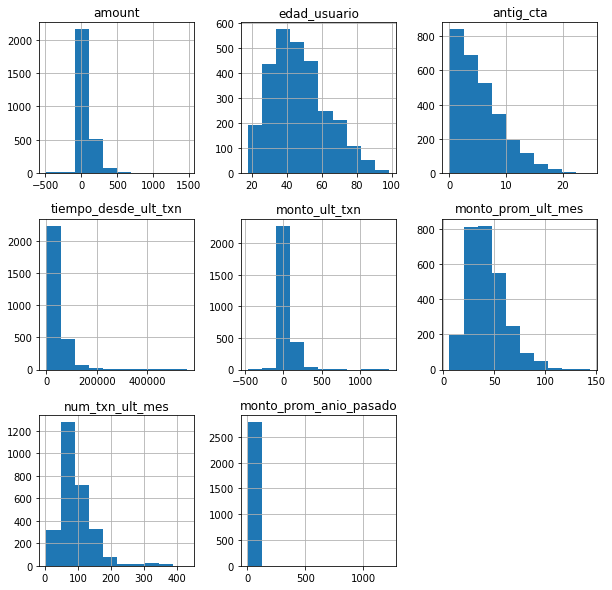

In [98]:
Xi.hist(figsize=(10,10))

In [103]:
for v,li,ls in Xi.describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist():
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex'] = Xi.filter(like='ex_').max(axis=1)

In [104]:
Xi['ex'].value_counts(1)

0   0.87
1   0.13
Name: ex, dtype: float64

In [105]:
Xi[um] = train[um]

In [110]:
gmm = GaussianMixture(n_components=10)

In [111]:
gmm.fit(Xi[varc])

GaussianMixture(n_components=10)

In [113]:
Xi['ex_mv'] = gmm.predict(Xi[varc])

In [115]:
Xi['ex_mv'].value_counts(1)

7   0.22
8   0.20
1   0.16
6   0.13
2   0.12
0   0.09
5   0.08
3   0.01
9   0.00
4   0.00
Name: ex_mv, dtype: float64

array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'edad_usuario'}>,
        <AxesSubplot:title={'center':'antig_cta'}>],
       [<AxesSubplot:title={'center':'tiempo_desde_ult_txn'}>,
        <AxesSubplot:title={'center':'monto_ult_txn'}>,
        <AxesSubplot:title={'center':'monto_prom_ult_mes'}>],
       [<AxesSubplot:title={'center':'num_txn_ult_mes'}>,
        <AxesSubplot:title={'center':'monto_prom_anio_pasado'}>,
        <AxesSubplot:>]], dtype=object)

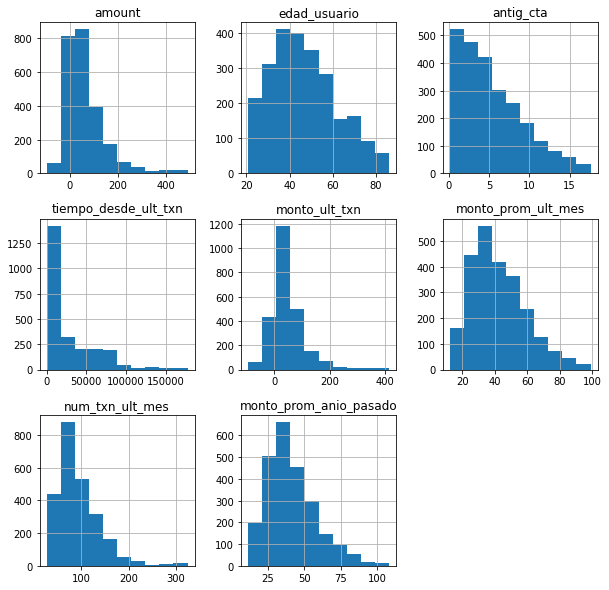

In [119]:
Xi.loc[Xi['ex']==0].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)[varc].hist(figsize=(10,10))

array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'edad_usuario'}>,
        <AxesSubplot:title={'center':'antig_cta'}>],
       [<AxesSubplot:title={'center':'tiempo_desde_ult_txn'}>,
        <AxesSubplot:title={'center':'monto_ult_txn'}>,
        <AxesSubplot:title={'center':'monto_prom_ult_mes'}>],
       [<AxesSubplot:title={'center':'num_txn_ult_mes'}>,
        <AxesSubplot:title={'center':'monto_prom_anio_pasado'}>,
        <AxesSubplot:>]], dtype=object)

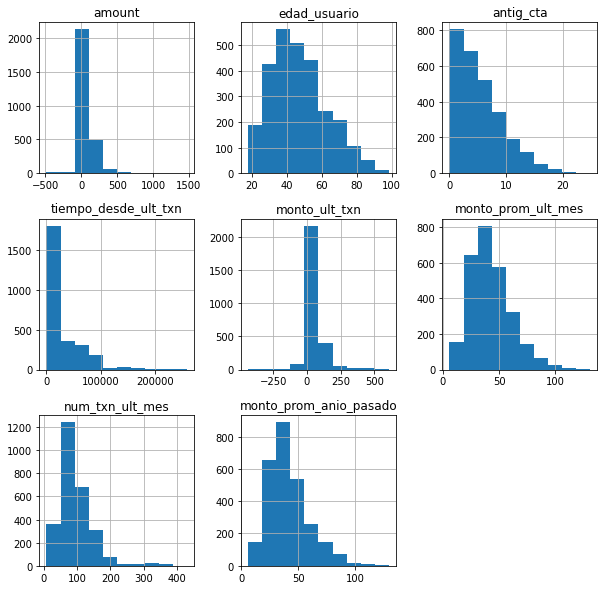

In [120]:
Xi.loc[~Xi['ex_mv'].isin([3,9,4])].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)[varc].hist(figsize=(10,10))

In [124]:
Xi = Xi.loc[~Xi['ex_mv'].isin([3,9,4])].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)

In [126]:
Xi.head()

,amount,edad_usuario,antig_cta,tiempo_desde_ult_txn,monto_ult_txn,monto_prom_ult_mes,num_txn_ult_mes,monto_prom_anio_pasado,ex,id_txn
0,7.62,21.50,2.40,6240.00,6.27,66.71,103.00,56.15,0,4574298
1,38.63,63.90,2.40,35940.00,3.24,46.63,122.00,48.87,0,7560347
2,83.31,35.10,1.60,4380.00,0.55,28.15,102.00,26.13,0,9284378
3,122.95,54.10,17.30,6180.00,60.31,16.47,104.00,16.08,0,8295122
4,1.71,77.40,2.00,1380.00,140.00,23.76,150.00,26.79,0,16070544


#### Multicolinealidad

In [128]:
vc = VarClusHi(df=Xi,feat_list=varc)
vc.varclus()

In [139]:
best = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])

#### Poder Predictivo

In [145]:
Xi = Xi.merge(train[um+vart],on=um,how='inner')

In [140]:
sk = SelectKBest(k=len(best))

In [148]:
sk.fit(Xi[best],Xi[vart[0]])

SelectKBest(k=4)

In [155]:
pd.DataFrame(zip(best,sk.scores_),
columns=['var','score']).sort_values(by='score',ascending=False).set_index('var').iplot(kind='bar',color='purple')

In [158]:
best.remove('monto_prom_ult_mes')

In [159]:
best

['tiempo_desde_ult_txn', 'antig_cta', 'monto_ult_txn']

array([[<AxesSubplot:title={'center':'tiempo_desde_ult_txn'}>,
        <AxesSubplot:title={'center':'antig_cta'}>],
       [<AxesSubplot:title={'center':'monto_ult_txn'}>, <AxesSubplot:>]],
      dtype=object)

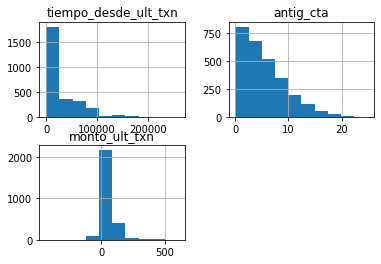

In [161]:
Xi[best].hist()

#### Consideraciones Finales

In [162]:
im.fit(train[best])

SimpleImputer(strategy='median')

### Discreto

In [163]:
def freq(df:pd.DataFrame,var:list):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().sort_index()
        aux.columns = ['FA']
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.cumsum()
        print(f'****Tabla de frecuencias  {v}  ***\n\n')
        print(aux)
        print("\n"*3)

In [165]:
for v in vard:
    train[v] = train[v].fillna('MISSING')

In [166]:
freq(train,vard)

****Tabla de frecuencias  rej_reason  ***


                                FA   FR   FAA  FRA
Bad PIN                         41 0.01    41 0.01
Bad PIN,Insufficient Balance     4 0.00    45 0.02
Bad PIN,Technical Glitch         1 0.00    46 0.02
Insufficient Balance            33 0.01    79 0.03
MISSING                       2717 0.97  2796 1.00
Technical Glitch                 4 0.00  2800 1.00




****Tabla de frecuencias  txn_type  ***


     FA   FR   FAA  FRA
C   595 0.21   595 0.21
S  2205 0.79  2800 1.00




****Tabla de frecuencias  hora  ***


     FA   FR   FAA  FRA
0    14 0.01    14 0.01
1    11 0.00    25 0.01
2    12 0.00    37 0.01
3    18 0.01    55 0.02
4    12 0.00    67 0.02
5    26 0.01    93 0.03
6    93 0.03   186 0.07
7   168 0.06   354 0.13
8   170 0.06   524 0.19
9   227 0.08   751 0.27
10  280 0.10  1031 0.37
11  260 0.09  1291 0.46
12  250 0.09  1541 0.55
13  232 0.08  1773 0.63
14  230 0.08  2003 0.72
15  185 0.07  2188 0.78
16  182 0.07  2370 0.85
17   92

In [168]:
def normalizar(df:pd.DataFrame,var:str,umbral:float=0.05)->tuple:
    aux = df[var].value_counts(1).to_frame()
    aux['map'] = np.where(aux[var]<umbral,'Otros',aux.index)
    if aux.loc[aux['map']=='Otros'][var].sum()<umbral:
        aux['map'].replace({'Otros':aux.head(1)['map'].values[0]},inplace=True)
    aux.drop(var,axis=1,inplace=True)
    return var,aux['map'].to_dict()

In [174]:
mapa_norm = list(map(lambda v:normalizar(train,v),vard))

In [176]:
for v,mapa in mapa_norm:
    train[f'n_{v}'] = train[v].map(mapa)

In [177]:
varn = [v for v in train.columns if v[:2]=='n_']

In [179]:
unarias = [v for v in varn if train[v].nunique()==1]
unarias

['n_rej_reason', 'n_horas_frec', 'n_dias_frec']

In [180]:
varn = [v for v in varn if v not in unarias]

In [181]:
varn

['n_txn_type', 'n_hora', 'n_mes', 'n_diasem', 'n_dif_estado']

## Espacios Vectoriales a Trabajar

### Espacio $\mathcal{X}$

In [185]:
X = Xi[um+best].copy().merge(train[um+varn],on=um,how='inner')
X.head()

,id_txn,tiempo_desde_ult_txn,antig_cta,monto_ult_txn,n_txn_type,n_hora,n_mes,n_diasem,n_dif_estado
0,4574298,6240.00,2.40,6.27,S,10,12,S,False
1,7560347,35940.00,2.40,3.24,C,Otros,2,M,False
2,9284378,4380.00,1.60,0.55,S,14,6,J,False
3,8295122,6180.00,17.30,60.31,C,16,4,M,False
4,16070544,1380.00,2.00,140.00,C,15,5,X,False


In [186]:
oh = OneHotEncoder(drop='if_binary')

In [187]:
oh.fit(X[varn])

OneHotEncoder(drop='if_binary')

In [193]:
X[oh.get_feature_names_out()] = oh.transform(X[varn]).toarray()

In [195]:
X.drop(varn,axis=1,inplace=True)

In [196]:
X.head()

,id_txn,tiempo_desde_ult_txn,antig_cta,monto_ult_txn,n_txn_type_S,n_hora_10,n_hora_11,n_hora_12,n_hora_13,n_hora_14,n_hora_15,n_hora_16,n_hora_7,n_hora_8,n_hora_9,n_hora_Otros,n_mes_1,n_mes_10,n_mes_11,n_mes_12,n_mes_2,n_mes_3,n_mes_4,n_mes_5,n_mes_6,n_mes_7,n_mes_8,n_mes_9,n_diasem_D,n_diasem_J,n_diasem_L,n_diasem_M,n_diasem_S,n_diasem_V,n_diasem_X,n_dif_estado_True
0,4574298,6240.00,2.40,6.27,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,7560347,35940.00,2.40,3.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,9284378,4380.00,1.60,0.55,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,8295122,6180.00,17.30,60.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,16070544,1380.00,2.00,140.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [197]:
var = best+list(oh.get_feature_names_out())

### Espacio $\mathcal{X}_{[0,1]}$

In [203]:
sc01 = MinMaxScaler()
sc01.fit(X[var])
X01 = pd.DataFrame(sc01.transform(X[var]),columns=var)
X01.insert(0,um[0],X[um])

In [205]:
X01[var].describe()

,tiempo_desde_ult_txn,antig_cta,monto_ult_txn,n_txn_type_S,n_hora_10,n_hora_11,n_hora_12,n_hora_13,n_hora_14,n_hora_15,n_hora_16,n_hora_7,n_hora_8,n_hora_9,n_hora_Otros,n_mes_1,n_mes_10,n_mes_11,n_mes_12,n_mes_2,n_mes_3,n_mes_4,n_mes_5,n_mes_6,n_mes_7,n_mes_8,n_mes_9,n_diasem_D,n_diasem_J,n_diasem_L,n_diasem_M,n_diasem_S,n_diasem_V,n_diasem_X,n_dif_estado_True
count,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00
mean,0.11,0.22,0.46,0.79,0.10,0.09,0.09,0.08,0.08,0.07,0.07,0.06,0.06,0.08,0.22,0.09,0.09,0.09,0.09,0.09,0.09,0.07,0.07,0.08,0.08,0.08,0.09,0.16,0.16,0.13,0.14,0.13,0.14,0.14,0.17
std,0.14,0.17,0.07,0.41,0.30,0.29,0.28,0.28,0.27,0.25,0.25,0.24,0.24,0.27,0.41,0.28,0.28,0.28,0.29,0.28,0.28,0.25,0.26,0.27,0.27,0.28,0.28,0.37,0.37,0.33,0.35,0.33,0.35,0.35,0.38
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,0.08,0.43,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.05,0.18,0.45,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.17,0.31,0.48,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Espacio estandarizado ($\mu=0;\sigma=1$) $\mathcal{X}_s$

In [206]:
sc = StandardScaler()
sc.fit(X[var])
Xs = pd.DataFrame(sc.transform(X[var]),columns=var)
Xs.insert(0,um[0],X[um])

In [207]:
Xs.describe()

,id_txn,tiempo_desde_ult_txn,antig_cta,monto_ult_txn,n_txn_type_S,n_hora_10,n_hora_11,n_hora_12,n_hora_13,n_hora_14,n_hora_15,n_hora_16,n_hora_7,n_hora_8,n_hora_9,n_hora_Otros,n_mes_1,n_mes_10,n_mes_11,n_mes_12,n_mes_2,n_mes_3,n_mes_4,n_mes_5,n_mes_6,n_mes_7,n_mes_8,n_mes_9,n_diasem_D,n_diasem_J,n_diasem_L,n_diasem_M,n_diasem_S,n_diasem_V,n_diasem_X,n_dif_estado_True
count,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00,2751.00
mean,10920049.20,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00
std,6371339.54,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,8848.00,-0.77,-1.28,-6.65,-1.91,-0.33,-0.32,-0.31,-0.30,-0.30,-0.27,-0.27,-0.25,-0.25,-0.30,-0.53,-0.31,-0.30,-0.31,-0.32,-0.31,-0.30,-0.27,-0.28,-0.29,-0.29,-0.30,-0.31,-0.44,-0.44,-0.38,-0.41,-0.38,-0.41,-0.40,-0.45
25%,5073737.00,-0.69,-0.80,-0.52,0.52,-0.33,-0.32,-0.31,-0.30,-0.30,-0.27,-0.27,-0.25,-0.25,-0.30,-0.53,-0.31,-0.30,-0.31,-0.32,-0.31,-0.30,-0.27,-0.28,-0.29,-0.29,-0.30,-0.31,-0.44,-0.44,-0.38,-0.41,-0.38,-0.41,-0.40,-0.45
50%,11122216.00,-0.44,-0.21,-0.22,0.52,-0.33,-0.32,-0.31,-0.30,-0.30,-0.27,-0.27,-0.25,-0.25,-0.30,-0.53,-0.31,-0.30,-0.31,-0.32,-0.31,-0.30,-0.27,-0.28,-0.29,-0.29,-0.30,-0.31,-0.44,-0.44,-0.38,-0.41,-0.38,-0.41,-0.40,-0.45
75%,16679454.50,0.43,0.58,0.32,0.52,-0.33,-0.32,-0.31,-0.30,-0.30,-0.27,-0.27,-0.25,-0.25,-0.30,-0.53,-0.31,-0.30,-0.31,-0.32,-0.31,-0.30,-0.27,-0.28,-0.29,-0.29,-0.30,-0.31,-0.44,-0.44,-0.38,-0.41,-0.38,-0.41,-0.40,-0.45
max,21498595.00,6.34,4.64,7.74,0.52,2.99,3.13,3.21,3.33,3.35,3.75,3.77,3.96,3.93,3.35,1.89,3.23,3.28,3.23,3.10,3.20,3.28,3.67,3.57,3.43,3.41,3.30,3.23,2.29,2.29,2.65,2.43,2.61,2.45,2.48,2.21


### Espacio de componentes principales (combinación lineal ortogonal) $\mathcal{X}_p$

In [216]:
pipe_pca = make_pipeline(StandardScaler(),PCA(0.9),MinMaxScaler())

In [217]:
pipe_pca.fit(X[var])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.9)),
                ('minmaxscaler', MinMaxScaler())])

In [218]:
pipe_pca.steps[1][-1].explained_variance_ratio_.cumsum()

array([0.04335126, 0.08253324, 0.12095575, 0.15842191, 0.19410096,
       0.22957225, 0.2642485 , 0.29871779, 0.33271935, 0.36625506,
       0.3995707 , 0.43237726, 0.46459214, 0.49650807, 0.52807835,
       0.55934221, 0.59041047, 0.62102665, 0.6513638 , 0.68143294,
       0.71125259, 0.74065925, 0.76976308, 0.79826933, 0.82639428,
       0.85407843, 0.88137156, 0.90846658])

In [225]:
Xp = pd.DataFrame(pipe_pca.transform(X[var]))
Xp.insert(0,um[0],X[um])

array([[<AxesSubplot:title={'center':'id_txn'}>,
        <AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>],
       [<AxesSubplot:title={'center':'14'}>,
        <AxesSubplot:title={'center':'15'}>,
        <AxesSubplot:title={'center':'16'}>,
        <AxesSubplot:title={'center':'17'}>,
        <AxesSubplot:title={'center':'18'}>],
       [<AxesSubplot:title={'center':'19'}>,
        <AxesSubplot:title={'center':'20'}>,
        <Axe

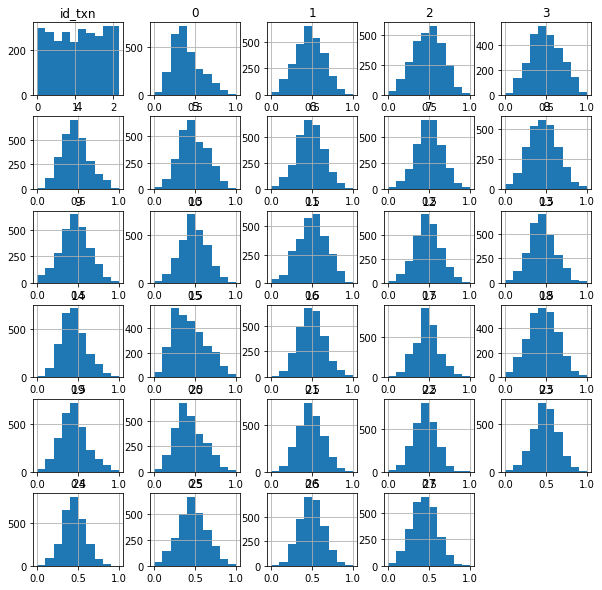

In [227]:
Xp.hist(figsize=(10,10))

### Espacio Weight of Evidence (WoE) $\mathcal{X}_w$

In [230]:
Xw = Xi[um+best+vart].copy().merge(train[um+varn],on=um,how='inner')

In [231]:
Xw.head()

,id_txn,tiempo_desde_ult_txn,antig_cta,monto_ult_txn,is_fraud,n_txn_type,n_hora,n_mes,n_diasem,n_dif_estado
0,4574298,6240.00,2.40,6.27,0,S,10,12,S,False
1,7560347,35940.00,2.40,3.24,0,C,Otros,2,M,False
2,9284378,4380.00,1.60,0.55,1,S,14,6,J,False
3,8295122,6180.00,17.30,60.31,1,C,16,4,M,False
4,16070544,1380.00,2.00,140.00,0,C,15,5,X,False


#### Discretizar variables continuas

In [234]:
def discretizar(df:pd.DataFrame,v:str)->pd.DataFrame:
    aux = df[um+[v]].copy()
    l = [d for _,d in aux.groupby(aux[v].isnull())]
    if len(l)==2:
        nm,m  = l
    else:
        nm,m = l[0], l[0].loc[l[0].index==-1]
    m.reset_index(drop=True,inplace=True)
    nm.reset_index(drop=True,inplace=True)
    m[v].fillna('MISSING',inplace=True)

    kb = KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')

    kb.fit(nm[[v]])

    nm['d'] = kb.transform(nm[[v]])

    nm['d'].value_counts(1)
    mapa = nm[[v,'d']].groupby('d').agg(['min','max'])
    mapa.columns = ['min','max']
    mapa['intervalo'] = mapa.index.astype(int).map(lambda x:'%02d. '%(x+1))+mapa['min'].astype(str)+'|'+mapa['max'].astype(str)
    mapa.drop(['min','max'],axis=1,inplace=True)
    nm[v] = nm['d'].replace(mapa['intervalo'].to_dict())
    return pd.concat([nm[um+[v]],m[um+[v]]],ignore_index=True)

In [236]:
cruzar = lambda x,y:x.merge(y,on=um,how='outer')

In [239]:
Xwd = reduce(cruzar,map(lambda v:discretizar(Xw,v),best))

In [241]:
Xw = Xwd.merge(Xw[um+varn+vart],on=um,how='inner')

In [242]:
Xw.head()

,id_txn,tiempo_desde_ult_txn,antig_cta,monto_ult_txn,n_txn_type,n_hora,n_mes,n_diasem,n_dif_estado,is_fraud
0,4574298,01. 60.0|51900.0,01. 0.0|4.9,03. 0.0|189.79,S,10,12,S,False,0
1,7560347,01. 60.0|51900.0,01. 0.0|4.9,03. 0.0|189.79,C,Otros,2,M,False,0
2,9284378,01. 60.0|51900.0,01. 0.0|4.9,03. 0.0|189.79,S,14,6,J,False,1
3,8295122,01. 60.0|51900.0,04. 15.0|19.8,03. 0.0|189.79,C,16,4,M,False,1
4,16070544,01. 60.0|51900.0,01. 0.0|4.9,03. 0.0|189.79,C,15,5,X,False,0


In [243]:
def codif_woe(df:pd.DataFrame,v:str,tgt:str)->tuple:
    aux = df.pivot_table(index=v,
              columns=tgt,
              values=um[0],
              aggfunc='count',
              fill_value=0)
    aux/=aux.sum()
    aux['w'] = np.log(aux[0]/aux[1])
    aux.drop(range(2),axis=1,inplace=True)
    return v,aux['w'].to_dict()

In [246]:
mapa_woe = list(map(lambda v:codif_woe(Xw,v,vart[0]),best+varn))

In [247]:
for v,mapa in mapa_woe:
    Xw[v] = Xw[v].map(mapa)

In [248]:
Xw.head()

,id_txn,tiempo_desde_ult_txn,antig_cta,monto_ult_txn,n_txn_type,n_hora,n_mes,n_diasem,n_dif_estado,is_fraud
0,4574298,-0.04,-0.17,0.01,-0.21,-0.46,-0.34,0.26,0.20,0
1,7560347,-0.04,-0.17,0.01,0.81,0.97,-0.20,-0.05,0.20,0
2,9284378,-0.04,-0.17,0.01,-0.21,-0.38,0.09,-0.22,0.20,1
3,8295122,-0.04,0.43,0.01,0.81,0.24,-0.00,-0.05,0.20,1
4,16070544,-0.04,-0.17,0.01,0.81,-0.32,0.06,0.15,0.20,0
